<a href="https://colab.research.google.com/github/DL-ECE/tp-1-deeplearningbasics-salimlouhmadi/blob/master/rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP-1 DLBasics

## Digit classification using the MNIST dataset

In this notebook you will train your first neural network. Feel free to look back at the Lecture-1 slides to complete the cells below. 

#### Install dependencies freeze by poetry 


In [1]:
#!python3 -m pip install --upgrade pip
#!python3 -m pip install matplotlib numpy scikit-learn==0.23.2


#### Import the different module we will need in this notebook 

All the dependencies are installed. Below we import them and will be using them in all our notebooks.

Please feel free to look arround and look at their API. 

The student should be limited to these imports to complete this work.


In [2]:
# We import some python standard librairy utility function 
# see the [python doc](https://docs.python.org/3.6/library/functools.html?highlight=func#module-functools) for more info 
from functools import reduce 
import random 

# To create some plot and figures: matplolib [matplotlib doc](https://matplotlib.org/)
# To do compute on matrix and vectors: [numpy doc](https://numpy.org/)
# To do some classical Machine Learning: [sklearn doc](https://scikit-learn.org/stable/index.html)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [3]:
# In order to have some reproducable results and easier debugging 
# we fix the seed of random.
random.seed(1342)
np.random.seed(1342)

## Data preparation (3 pts)

As seen in the lecture one of the earlier use case for deep learning was digit recognition. 

The dataset we will use today is the MNISTdataset http://yann.lecun.com/exdb/mnist/. 

One image will be represented a vector (a 28x28 image will be represented as vector with 784 entries).

Thus, we will end up with a n_examples x 784 matrix to represent the images in the dataset.


In [4]:
mnist_data, mnist_target = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
# Let's warmup and answer this first question
# Replace the None with you answer.
# How many image are in this dataset ? 
def data_length(dataset: np.array, target: np.array):
    """Function to compute the length of the dataset and the length of the target labels."""
    dataset_length = np.shape(dataset)[0]
    target_length = np.shape(target)[0]
    return dataset_length, target_length

print(data_length(mnist_data, mnist_target))

(70000, 70000)


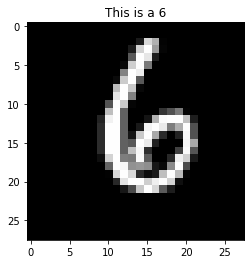

In [6]:
# Let's look at on image from this dataset 
def plot_one_image(dataset: np.array, target: np.array, image_index: int):
    """Function to plot the image at the given index."""
    image = dataset[image_index].reshape(28,28)
    target = target[image_index]
    plt.imshow(image, cmap='gray')
    plt.title(f"This is a {target}")


plot_one_image(mnist_data, mnist_target ,2300)

In [7]:

# In a similar fashion to classical machine learning, we will create a test split to known if the neural network is learning well.

X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_target, test_size=0.33, random_state=1342)

# You the 2 function below to check if they are working properly on this divided dataset.

X_train_length, y_train_length = data_length(X_train, y_train)
X_test_length, y_test_length = data_length(X_test, y_test)

assert X_train_length == y_train_length and X_train_length == 46900
assert X_test_length == y_test_length and X_test_length == 23100


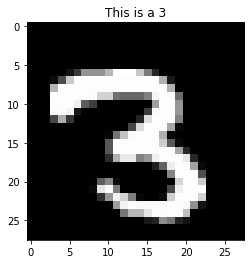

In [8]:
plot_one_image(X_train, y_train , 120)

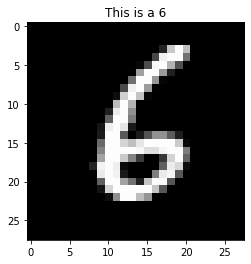

In [9]:
plot_one_image(X_test, y_test , 250)

In [10]:
# It's important to normalize the data before feeding it into the neural network
def normalize_data(dataset: np.array) -> np.array:
    return dataset/255
normalized_data = normalize_data(mnist_data)
X_train= normalize_data(X_train)
X_test = normalize_data(X_test)

It's also important to find a good representation of the target.

In this notebook it will be one-hot vector. 

Complete the below function to turn the target vector into a one-hot matrix.

For example, a `[0,1,9]` vector will become the following matrix:

`[[1,0,0,0,0,0,0,0,0,0],
  [0,1,0,0,0,0,0,0,0,0],
  [0,0,0,0,0,0,0,0,0,1]]`



In [11]:
def target_to_one_hot(target : np.array) -> np.array:
    one_hot_matrix = np.zeros((len(target),10))
    for i in range(len(target)):
      label = int(target[i])
      one_hot_matrix[i,label]=1
    return one_hot_matrix
a = [1,2,9]
print(a)
print(target_to_one_hot(a))
y_test = target_to_one_hot(y_test)
y_train = target_to_one_hot(y_train)

[1, 2, 9]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Useful functions (3 pts)

Implement the sigmoid function, its derivative and the softmax function:

In [12]:
def sigmoid(M: np.array) -> np.array:
  """Compute the sigmoid function""" 
  return 1/(1+np.exp(-M))

In [13]:
def d_sigmoid(M: np.array)-> np.array:
    """Compute the derivative of the sigmoid""" 
    return sigmoid(M)*(1-sigmoid(M))

In [14]:
def softmax(X: np.array)-> np.array:
    """Apply a softmax to the input array"""
    #soft= np.exp(X)/[np.exp(X[i]) for i in range[0,len(X)]]
    exp = np.exp(X)
    som_exp = np.sum(np.exp(X),axis=1).reshape(-1,1)
    return exp/som_exp

## Feed forward NN

Now that the data is prepared it's time to create a neural network to learn on this dataset.

You can look back at the lecture slides and need to replace the None in the below function in order to have the building blocks of this first neural network. 

To do so we are now going to create the FFNN class. It will take list of integers to represent the network.

One element in the list corresponds to the number of neurones in the layer.
`config = [784, 3, 4, 10]` will be an acceptable config: 
- inputs are 1x784 vectors 
- the model output should be a vector of size 10 to classify between 10 classes.
- in the middle the hidden layer are fully customizable

You have to do some implementations and replace the None assignment (variable = None). Do not do it for the Layer object.

Warning: None return type for some methods are not supposed to be affected

In [15]:
class Layer:
    def __init__(self):
        self.Z = None
        self.W = None
        self.D = None
        self.F = None
        self.activation = None

In [16]:
class FFNN:
    def __init__(self, config, minibatch_size=100, learning_rate=0.1):
        self.layers = []
        self.nlayers = len(config)
        self.minibatch_size = minibatch_size
        self.learning_rate = learning_rate
        
        input_data = Layer()
        # TODO: initialize the Z matrix with the a matrix containing only zeros
        # its shape should be (minibatch_size, config[0])
        input_data.Z = np.zeros((minibatch_size, config[0]))
        self.layers.append(input_data)
        
        for i in range(1, len(config)):
            nnodes = config[i]
            layer  = Layer()
            nlines_prev, ncols_prev = self.layers[i - 1].Z.shape
            # TODO: initilize the weight matrix W in the layer with a random normal distribution
            # its shape should be (ncols_prev, nnodes)
            layer.W = np.random.normal(0,1,(ncols_prev, nnodes))
            # TODO: initilize the matrix Z in the layer with a matrix containing only zeros
            # its shape should be (nlines_prev, nnodes)
            layer.Z = np.zeros((nlines_prev, nnodes))
            # TODO: use the sigmoid activation function
            layer.activation = sigmoid 
            self.layers.append(layer) 
            
            
        # TODO: Your last layer activation should be a softmax
        self.layers[-1].activation = softmax
        

    def one_step_forward(self, signal: np.array, cur_layer: Layer)-> np.array:
        # Compute the F and Z matrix for the current layer and return Z
        
        # TODO: Compute the dot product betzeen the signal and the current layer W matrix
        S = np.dot(signal,cur_layer.W)
        # TODO: Compute the F matrix of the current layer
        cur_layer.F = np.transpose((d_sigmoid(S)))
        # Compute the activation od the current layer
        cur_layer.Z = cur_layer.activation(S)
        return cur_layer.Z
       
    def forward_pass(self, input_data: np.array)-> np.array:
        # TODO: perform the whole forward pass using the on_step_forward function
        self.layers[0].Z = input_data
        for i in range(0,self.nlayers-1):
            self.layers[i+1].Z = self.one_step_forward(self.layers[i].Z, self.layers[i+1])
        return self.layers[-1].Z
    
    def one_step_backward(self, prev_layer: Layer, cur_layer: Layer)-> Layer:
        # TODO: Compute the D matrix of the current layer using the previous layer and return the current layer
        Di = cur_layer.F* np.dot(prev_layer.W,prev_layer.D)
        cur_layer.D = Di
        return cur_layer
        
    def backward_pass(self, D_out: np.array)-> None:
        self.layers[-1].D = D_out.T
        # TODO: Compute the D matrix for all the layers (excluding the first one which corresponds to the input itself)
        # (you should only use self.layers[1:])
        
        for i in range(1,self.nlayers-1):
            self.layers[-(i+1)] = self.one_step_backward(self.layers[-i],self.layers[-(i+1)])
 
    def update_weights(self, cur_layer: Layer, next_layer: Layer)-> Layer:
        # TODO: Update the W matrix of the next_layer using the current_layer and the learning rate
        # and return the next_layer
        next_layer.W = next_layer.W -self.learning_rate*(np.dot(next_layer.D,cur_layer.Z)).T
        return next_layer
    
    def update_all_weights(self)-> None:
        # TODO: Update all W matrix using the update_weights function
        for i in range(self.nlayers-1):
          self.layers[i+1] = self.update_weights(self.layers[i],self.layers[i+1])
        
        
    def get_error(self, y_pred: np.array, y_batch: np.array)-> float:
        # TODO: return the accuracy on the predictions
        # the accuracy should be in the [0.0, 1.0] range
        prediction = np.argmax(y_pred,axis=1)
        c = np.argmax(y_batch,axis=1)
        s = 0 
        for i in range (len(prediction)):
          if prediction[i] == c[i] :
            s +=1
        return s/len(prediction)
    
    def get_test_error(self, X: np.array, y: np.array)-> float:
        # TODO: Compute the accuracy using the get_error function
        nbatch = X.shape[0]
        error_sum = 0.0
        for i in range(0, nbatch):
            X_batch = X[i,:,:].reshape(self.minibatch_size, -1)
            y_batch = y[i,:,:].reshape(self.minibatch_size, -1)           
            # TODO: get y_pred using the forward pass
            y_pred = self.forward_pass(X_batch)
            error_sum += self.get_error(y_pred,y_batch)
        return error_sum / nbatch
            
        
    def train(self, nepoch, X_train, y_train, X_test, y_test)-> float:
        X_train = X_train.reshape(-1, self.minibatch_size, 784)
        y_train = y_train.reshape(-1, self.minibatch_size, 10)
        
        X_test = X_test.reshape(-1, self.minibatch_size, 784)
        y_test = y_test.reshape(-1, self.minibatch_size, 10)
        
        # TODO: Get the number of batch based on X_train's shape
        nbatch = X_train.shape[0]
        error_test = 0.0
        for epoch in range(0, nepoch):
            error_sum_train = 0.0
            for i in range(0, nbatch):
                X_batch = X_train[i,:, :]
                y_batch = y_train[i,:, :]
        
                y_pred = self.forward_pass(X_batch)
                self.backward_pass(y_pred - y_batch)
                self.update_all_weights()
                error_sum_train += self.get_error(y_pred, y_batch)
            error_test = self.get_test_error(X_test, y_test)
            print(f"Training accuracy: {error_sum_train / nbatch:.3f}, Test accuracy: {error_test:.3f}")
        return error_test

## Training phase (12 pts)

Now, it is time to train the model !!

You can play with the different parameters (minibatch_size, nepoch, learning_rate and the number of hidden layers)

It's on 12 points because there is a lot of functions to fill but also we want the training best training accuracy. 

To have all the point your neural network needs to have a Test accuracy > 92 % !! 

In [17]:
minibatch_size = 5
nepoch = 10
learning_rate = 0.1

ffnn = FFNN(config=[784, 200, 200, 10], minibatch_size=minibatch_size, learning_rate=learning_rate)

In [18]:
assert X_train.shape[0] % minibatch_size == 0
assert X_test.shape[0] % minibatch_size == 0

err = ffnn.train(nepoch, X_train, y_train, X_test, y_test)

Training accuracy: 0.833, Test accuracy: 0.899
Training accuracy: 0.915, Test accuracy: 0.925
Training accuracy: 0.938, Test accuracy: 0.939
Training accuracy: 0.947, Test accuracy: 0.946
Training accuracy: 0.956, Test accuracy: 0.950
Training accuracy: 0.963, Test accuracy: 0.955
Training accuracy: 0.965, Test accuracy: 0.953
Training accuracy: 0.970, Test accuracy: 0.957
Training accuracy: 0.973, Test accuracy: 0.959
Training accuracy: 0.977, Test accuracy: 0.960


## Error analysis (2 pts)

Here we use a subset of the test data to try and find some miss classification.

It will help us understand why the neural network failed sometimes to classify images. 

2
2


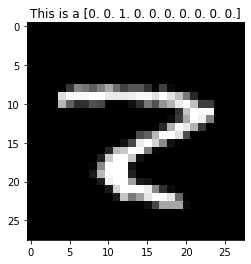

In [19]:
nsample = 1000
X_demo = X_test[:nsample,:]
y_demo = ffnn.forward_pass(X_demo)
y_true = y_test[:nsample,:]
#y_true = y_test[:nsample,:]
index_to_plot = 50 
plot_one_image(X_demo, y_true, index_to_plot)

# Compare to the prediction 
prediction = np.argmax(y_demo[index_to_plot,:])
true_target = np.argmax(y_true[index_to_plot,:])

# is it the same number ? 
print(prediction)
print(true_target)

In [20]:
# loop arround the demo test set and try to find a miss prediction
for i in range(0, nsample):   
    prediction =  np.argmax(y_demo[i,:]) # Todo
    true_target = np.argmax(y_true[i,:]) # Todo
    if prediction != true_target:
        # TODO
        print("prediction= " + str(prediction)+ "   true target = " +str(true_target))
        pass


prediction= 8   true target = 7
prediction= 8   true target = 7
prediction= 1   true target = 9
prediction= 7   true target = 4
prediction= 4   true target = 9
prediction= 5   true target = 3
prediction= 8   true target = 9
prediction= 3   true target = 2
prediction= 2   true target = 0
prediction= 9   true target = 7
prediction= 7   true target = 1
prediction= 7   true target = 9
prediction= 9   true target = 4
prediction= 5   true target = 8
prediction= 9   true target = 5
prediction= 3   true target = 9
prediction= 6   true target = 4
prediction= 2   true target = 0
prediction= 0   true target = 5
prediction= 8   true target = 0
prediction= 2   true target = 3
prediction= 8   true target = 5
prediction= 4   true target = 9
prediction= 7   true target = 4
prediction= 9   true target = 7
prediction= 6   true target = 1
prediction= 1   true target = 4
prediction= 0   true target = 2
prediction= 5   true target = 7
prediction= 4   true target = 9
prediction= 6   true target = 2
predicti

## Open analysis

in the cell below please explain you choice for all the parameters of your configuration: 

- minibatch_size
- nepoch
- config
- learning_rate

Also explain how the neural network behave when changing them ? 

## Open analysis answer

TODO

In [21]:
#La précision augmente lorsqu'on multiplie le nombre de couche cachées
#Il faut aussi garder un learning rate de l'ordre de 0.1 sinon problème d'over/underfitting